#  Using EUGENe to generate a BPNet model
This notebook uses full-on EUGENe code to train a base-pair resolution model in the BPNet style. 

In [33]:
# Import libraries
import torch
import numpy as np
import xarray as xr
import seqdata as sd
import seqpro as sp
from pathlib import Path
from bpnetlite import BPNet

from eugene import preprocess as pp

# Define paths
data_dir = Path("/cellar/shared/carterlab/data/ml4gland/ENCSR000EGM/data")
fasta = Path("/cellar/users/aklie/data/ml4gland/use_cases/avsec21/reference/hg38.fa")
peaks = data_dir / "peaks.bed"
signals = [data_dir / "plus.bw", data_dir / "minus.bw"]
controls = [data_dir / "control_plus.bw", data_dir / "control_minus.bw"]
control_samples = ['plus', 'minus']
bigwigs = signals + controls
sample_names = ['signal+', 'signal-', 'control+', 'control-']
out = '/cellar/users/dlaub/projects/ML4GLand/use_cases/avsec21/avsec21.zarr'

# Define training and validation chromosomes
training_chroms = ['chr{}'.format(i) for i in range(1, 17)]
valid_chroms = ['chr{}'.format(i) for i in range(18, 23)]

# Load data

In [34]:
# Load in the SeqData
sdata = sd.open_zarr(out)

In [35]:
# Split cov into control and signal
sdata['control'] = (
    sdata.cov.sel(cov_sample=['control+', 'control-'])
    .rename({'cov_sample': 'cov_strand'})
    .assign_coords({'cov_strand': ['+', '-']})
)
sdata['signal'] = (
    sdata.cov.sel(cov_sample=['signal+', 'signal-'])
    .rename({'cov_sample': 'cov_strand'})
    .assign_coords({'cov_strand': ['+', '-']})
)
sdata = sdata.drop_vars(['cov', 'cov_sample'])
sdata

<xarray.Dataset>
Dimensions:     (_sequence: 57244, _length: 2370, cov_strand: 2)
Coordinates:
  * cov_strand  (cov_strand) <U1 '+' '-'
Dimensions without coordinates: _sequence, _length
Data variables: (12/13)
    blockCount  (_sequence) uint64 dask.array<chunksize=(28622,), meta=np.ndarray>
    chrom       (_sequence) object dask.array<chunksize=(28622,), meta=np.ndarray>
    chromEnd    (_sequence) int64 dask.array<chunksize=(28622,), meta=np.ndarray>
    chromStart  (_sequence) int64 dask.array<chunksize=(28622,), meta=np.ndarray>
    itemRgb     (_sequence) object dask.array<chunksize=(28622,), meta=np.ndarray>
    name        (_sequence) object dask.array<chunksize=(28622,), meta=np.ndarray>
    ...          ...
    seq         (_sequence, _length) |S1 dask.array<chunksize=(2048, 2370), meta=np.ndarray>
    strand      (_sequence) object dask.array<chunksize=(28622,), meta=np.ndarray>
    thickEnd    (_sequence) int64 dask.array<chunksize=(28622,), meta=np.ndarray>
    thickStart  (_sequence) int64 dask.array<chunksize=(28622,), meta=np.ndarray>
    control     (_sequence, cov_strand, _length) uint16 dask.array<chunksize=(2048, 1, 2370), meta=np.ndarray>
    signal      (_sequence, cov_strand, _length) uint16 dask.array<chunksize=(2048, 1, 2370), meta=np.ndarray>
Attributes:
    length_dim:    _length
    max_jitter:    128
    sequence_dim:  _sequence

In [36]:
# Need to upper case the seqs for ohe
sdata["cleaned_seq"] = xr.DataArray(np.char.upper(sdata["seq"]), dims=["_sequence", "_length"])

In [37]:
# Check how many b'N' characters exist in "cleaned_seq"
(sdata["cleaned_seq"] == b"N").sum().values

array(4246)

In [38]:
# Load the training data into memory for faster training
sdata[['seq', 'control', 'signal']].load()

<xarray.Dataset>
Dimensions:     (_sequence: 57244, _length: 2370, cov_strand: 2)
Coordinates:
  * cov_strand  (cov_strand) <U1 '+' '-'
Dimensions without coordinates: _sequence, _length
Data variables:
    seq         (_sequence, _length) |S1 b'a' b't' b'c' b'a' ... b'C' b'C' b'C'
    control     (_sequence, cov_strand, _length) uint16 0 0 0 0 0 ... 0 0 0 0 0
    signal      (_sequence, cov_strand, _length) uint16 0 0 0 0 0 ... 0 0 0 0 0
Attributes:
    length_dim:    _length
    max_jitter:    128
    sequence_dim:  _sequence

In [39]:
# Keep only training and validation chromosomes
sdata = sdata.sel(_sequence=((sdata["chrom"].isin(training_chroms)) | (sdata["chrom"].isin(valid_chroms))).compute())

In [40]:
# Train-test split based on chromosomes
pp.train_test_chrom_split(sdata, test_chroms=valid_chroms)
sdata_train = sdata.sel(_sequence=(sdata["train_val"]==True).compute())
sdata_valid = sdata.sel(_sequence=(sdata["train_val"]==False).compute())

In [41]:
# Check that the chromosomes are correct
sdata_train["chrom"].to_series().value_counts(), sdata_valid["chrom"].to_series().value_counts()

(chr1     6085
 chr2     4260
 chr6     3557
 chr3     3437
 chr7     3220
 chr11    3055
 chr5     2990
 chr12    2801
 chr10    2668
 chr8     2480
 chr4     2378
 chr9     2173
 chr16    2120
 chr15    1915
 chr14    1601
 chr13    1063
 Name: chrom, dtype: int64,
 chr19    2387
 chr20    1589
 chr22    1301
 chr18    1086
 chr21     688
 Name: chrom, dtype: int64)

In [12]:
# Define training transformations
from eugene.dataload._augment import RandomRC

def seq_trans(x):
    x = np.char.upper(x)
    x = sp.ohe(x, sp.alphabets.DNA)
    x = x.swapaxes(1, 2)
    return x

def cov_dtype(x):
    return tuple(arr.astype('f4') for arr in x)

def jitter(x):
    return sp.jitter(*x, max_jitter=128, length_axis=-1, jitter_axes=0)

def to_tensor(x):
    return tuple(torch.tensor(arr, dtype=torch.float32) for arr in x)

def random_rc(x):
    return RandomRC(rc_prob=0.5)(*x)

# Get the train dataloader
train_dl = sd.get_torch_dataloader(
    sdata_train,
    sample_dims=['_sequence'],
    variables=['cleaned_seq', 'control', 'signal'],
    prefetch_factor=None,
    batch_size=32,
    transforms={
        ('cleaned_seq', 'control', 'signal'): jitter,
        'cleaned_seq': seq_trans,
        'signal': lambda x: x[..., 557:-557],
        ('control', 'signal'): cov_dtype,
        ('control', 'cleaned_seq', 'signal'): to_tensor,
        ('signal', 'control', 'cleaned_seq'): random_rc
    },
    return_tuples=True,
    shuffle=True,
)

In [13]:
# Test a batch
batch = next(iter(train_dl))
[x.shape for x in batch]

[torch.Size([32, 4, 2114]),
 torch.Size([32, 2, 2114]),
 torch.Size([32, 2, 1000])]

In [14]:
def seq_trans(x):
    x = sp.ohe(x, sp.alphabets.DNA)
    x = x.swapaxes(1, 2)
    x = x[..., 128:-128]
    return torch.as_tensor(x.astype('f4'))

def ctl_trans(x):
    x = x[..., 128:-128]
    return torch.as_tensor(x.astype('f4'))

def cov_trans(x):
    x = x[..., 128+557:-128-557]
    return torch.as_tensor(x.astype('f4'))

valid_dl = sd.get_torch_dataloader(
    sdata_valid,
    sample_dims=['_sequence'],
    variables=['cleaned_seq', 'control', 'signal'],
    prefetch_factor=None,
    batch_size=64,
    transforms={
        'cleaned_seq': seq_trans,
        'control': ctl_trans,
        'signal': cov_trans,
    },
    return_tuples=True,
    shuffle=False,
)

In [15]:
# Test a batch
batch = next(iter(valid_dl))
[x.shape for x in batch]

[torch.Size([64, 4, 2114]),
 torch.Size([64, 2, 2114]),
 torch.Size([64, 2, 1000])]

# Train a model

In [46]:
from eugene.models.zoo._profile_predictors import BPNet

/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/lightning_utilities/core/imports.py:116: UserWarning: Unbuilt egg for seqpro [unknown version] (/cellar/users/aklie/projects/ML4GLand/SeqPro)
  pkg_resources.require(self.requirement)


In [49]:
arch = BPNet(
    input_len=2114,
    output_dim=1000,
    n_outputs=2,
    n_control_tracks=2, 
    trimming=(2114 - 1000) // 2,
    name="BPNet"
)

In [48]:
batch = next(iter(train_dl))

NameError: name 'train_dl' is not defined

In [ ]:
outs = arch(batch[0], batch[1])
outs[0].shape, outs[1].shape

(torch.Size([32, 2, 1000]), torch.Size([32, 1]))

In [50]:
from eugene.models._ProfileModule import ProfileModule

In [36]:
model = ProfileModule(arch=arch)

In [37]:
outs = model(batch[0], batch[1])
outs[0].shape, outs[1].shape

(torch.Size([32, 2, 1000]), torch.Size([32, 1]))

In [38]:
outs = model.predict(batch[0], batch[1])
outs[0].shape, outs[1].shape

(torch.Size([32, 2, 1000]), torch.Size([32, 1]))

In [39]:
from eugene.train import fit

In [ ]:
fit(
    model=model,
    train_dataloader=train_dl,
    val_dataloader=valid_dl,
    epochs=50,
    gpus=1,
    early_stopping_metric=None,
    model_checkpoint_monitor="val_loss_epoch",
    log_dir="/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/logs/revision/bpnet",
    name="BPNet",
    version="v4"
)

# Generate a training curve and pull the stats for the best model

In [11]:
import pandas as pd
from eugene.plot._utils import tflog2pandas
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

In [3]:
# Keep only the columns with epoch in the name and drop the exact "epoch" value
df = tflog2pandas("/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/logs/revision/bpnet/BPNet/v4/events.out.tfevents.1687398202.carter-gpu-01.1151710.4")
df = df[df['metric'].str.contains('epoch')]
df = df[df['metric'] != 'epoch']
df.head()

,metric,value,step
5829,val_loss_epoch,270.847412,1431.0
5830,val_loss_epoch,268.144775,2863.0
5831,val_loss_epoch,267.465454,4295.0
5832,val_loss_epoch,266.231659,5727.0
5833,val_loss_epoch,265.921204,7159.0


In [12]:
# Flatten the df to make the step the index
eugene_log = df.pivot(index='step', columns='metric', values='value').reset_index()
eugene_log.head()

metric,step,train_loss_epoch,val_count_corr_epoch,val_count_loss_epoch,val_loss_epoch,val_profile_corr_epoch,val_profile_loss_epoch
0,1431.0,437.723328,0.292861,0.725085,270.847412,0.407059,270.122314
1,2863.0,403.583923,0.363934,0.977615,268.144775,0.415302,267.167206
2,4295.0,400.748596,0.356503,0.946092,267.465454,0.418510,266.519409
3,5727.0,399.091553,0.328651,0.712521,266.231659,0.420751,265.519196
4,7159.0,397.945557,0.360552,0.742331,265.921204,0.421732,265.178864


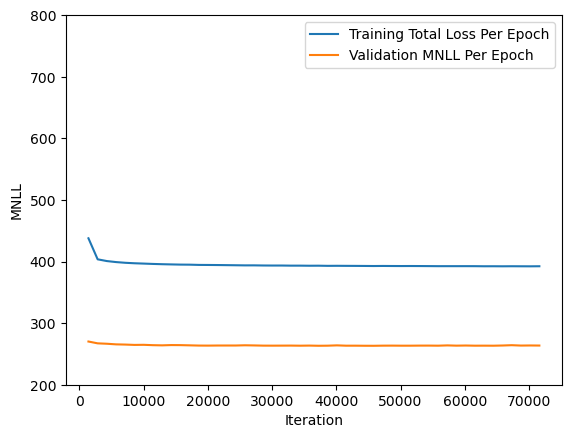

In [31]:
# Plot "MNLL" over "Iteration"
plt.plot(eugene_log["step"], eugene_log["train_loss_epoch"], label="Training Total Loss Per Epoch")
plt.plot(eugene_log["step"], eugene_log["val_profile_loss_epoch"], label="Validation MNLL Per Epoch")
plt.xlabel("Iteration")
plt.ylabel("MNLL")
plt.ylim(200, 800)
plt.legend()
plt.savefig("/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/figures/revision/bpnet/eugene_mnll.pdf", bbox_inches="tight", dpi=300)

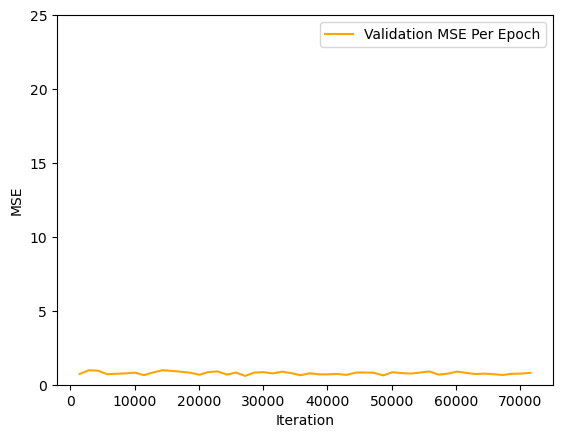

In [32]:
# Plot "MNLL" over "Iteration"
plt.plot(eugene_log["step"], eugene_log["val_count_loss_epoch"], label="Validation MSE Per Epoch", color="orange")
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.ylim(0, 25)
plt.legend()
plt.savefig("/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/figures/revision/bpnet/eugene_mse.pdf", bbox_inches="tight", dpi=300)

In [44]:
# Get the validation data
def seq_trans(x):
    x = x[..., 128:-128]
    np.char.upper(x)
    x = sp.ohe(x, sp.alphabets.DNA)
    x = x.swapaxes(1, 2)
    return torch.as_tensor(x.astype('f4'))

def ctl_trans(x):
    x = x[..., 128:-128]
    return torch.as_tensor(x.astype('f4'))

def cov_trans(x):
    x = x[..., 128+557:-128-557]
    return torch.as_tensor(x.astype('f4'))

X_valid = seq_trans(sdata_valid["cleaned_seq"].values)
X_ctl_valid = ctl_trans(sdata_valid["control"].values)
y_valid = cov_trans(sdata_valid["signal"].values)
X_valid.shape, X_ctl_valid.shape, y_valid.shape

(torch.Size([7051, 4, 2114]),
 torch.Size([7051, 2, 2114]),
 torch.Size([7051, 2, 1000]))

In [43]:
# Get a random batch of validation data
idx = np.random.choice(len(X_valid), size=32, replace=False)
X_valid = X_valid[idx]
X_ctl_valid = X_ctl_valid[idx]
y_valid = y_valid[idx]
X_valid.shape, X_ctl_valid.shape, y_valid.shape

(torch.Size([32, 4, 2114]),
 torch.Size([32, 2, 2114]),
 torch.Size([32, 2, 1000]))

In [52]:
model = ProfileModule.load_from_checkpoint("/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/logs/revision/bpnet/BPNet/v4/checkpoints/epoch=25-step=37232.ckpt", arch=arch)

In [53]:
y_profile, y_counts = model.predict(X_valid, X_ctl_valid)

z = y_profile.shape
y_profile = y_profile.reshape(y_profile.shape[0], -1)
y_profile = torch.nn.functional.log_softmax(y_profile, dim=-1)
y_profile = y_profile.reshape(*z)

In [54]:
from eugene.evaluate.metrics._profile_prediction import calculate_performance_measures

In [55]:
measures = calculate_performance_measures(y_profile, 
    y_valid, y_counts, kernel_sigma=7, 
    kernel_width=81, measures=['profile_mnll', 
    'profile_pearson', 'count_pearson', 'count_mse'])

profile_corr = measures['profile_pearson']
count_corr = measures['count_pearson']

valid_loss = measures['profile_mnll'].mean()
valid_loss += model.arch.alpha * measures['count_mse'].mean()

In [56]:
measures['profile_mnll'].mean().item()

263.2419128417969

In [57]:
measures['count_mse'].mean().item()

0.7754321098327637

In [58]:
np.nan_to_num(profile_corr).mean()

0.42818016

In [59]:
np.nan_to_num(count_corr).mean()

0.73949087

In [63]:
eugene_final_log = pd.Series(
    {
        "Epoch": 25,
        "Iteration": 37232,
        "Training Time": np.nan,
        "Validation Time": np.nan,
        "Training MNLL": np.nan,
        "Training Count MSE": np.nan,
        "Validation MNLL": measures['profile_mnll'].mean().item(),
        "Validation Profile Pearson": np.nan_to_num(profile_corr).mean(),
        "Validation Count Pearson": np.nan_to_num(count_corr).mean(),
        "Validation Count MSE": measures['count_mse'].mean().item(),
        "Saved?": True,
        "type": "EUGENe"
    }
)
eugene_final_log.to_csv("/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/logs/revision/bpnet/BPNet/bpnet.eugene.log.final", sep="\t", index=True, header=False)

# Scratch

# ProfileDataset

In [4]:
# Set paths
data_dir = "/cellar/users/aklie/data/eugene/avsec21/ENCSR000EGM/data"
reference_dir = "/cellar/users/aklie/data/eugene/avsec21/reference"
peaks = os.path.join(data_dir, "peaks.bed")
#peaks = "/cellar/users/aklie/data/eugene/avsec21/ENCSR000EGM/toy.bed"
seqs = os.path.join(reference_dir, "hg38.fa")
signals = [os.path.join(data_dir, "plus.bw"), os.path.join(data_dir, "minus.bw")]
controls = [os.path.join(data_dir, "control_plus.bw"), os.path.join(data_dir, "control_minus.bw")]

# Set training and validation chromosomes
training_chroms = ['chr{}'.format(i) for i in range(1, 17)]
valid_chroms = ['chr{}'.format(i) for i in range(18, 23)]

# Load data

In [5]:
from eugene.dataload import ProfileDataset

In [6]:
X_train, y_train, X_ctl_train = eu.dl.read_profile(peaks, seqs, signals, controls, max_jitter=128, chroms=training_chroms)
#X_val, y_val, X_ctl_val = eu.dl.read_profile(peaks, seqs, signals, controls, max_jitter=0, chroms=valid_chroms)

In [7]:
X_train.shape

torch.Size([45803, 4, 2370])

In [ ]:
X_val

In [658]:
#X_train_dataset = ProfileDataset(X_train, y_train, X_ctl_train)
X_val_dataset = ProfileDataset(X_val, y_val, X_ctl_val)

In [659]:
#X_train_loader = X_train_dataset.to_dataloader(batch_size=64, num_workers=4, shuffle=True)
X_val_loader = X_val_dataset.to_dataloader(batch_size=64, num_workers=4, shuffle=False)

# Instantiate a model

In [660]:
from eugene.models._profile_models import BPNet

model = BPNet(
    input_len=2114,
    output_dim=1000,
    n_outputs=2,
    n_control_tracks=2, 
    trimming=(2114 - 1000) // 2
).cuda()

In [661]:
batch = next(iter(X_dataloader_val))
outs = model(batch[0].cuda(), batch[1].cuda())
outs[0].shape, outs[1].shape

(torch.Size([64, 2, 1000]), torch.Size([64, 1]))

# Train with PyTorch Lightning

In [663]:
import pytorch_lightning as pl

: 

In [64]:
logging_dir = "/cellar/users/aklie/projects/ML4GLand/use_cases/avsec21/"
trainer = pl.Trainer(gpus=1, max_epochs=5, progress_bar_refresh_rate=20, logger=pl.loggers.TensorBoardLogger(logging_dir, name="models"))

/cellar/users/aklie/opt/miniconda3/envs/eugene_dev/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [65]:
trainer.fit(model, X_train_loader, X_val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Missing logger folder: /cellar/users/aklie/projects/ML4GLand/use_cases/avsec21/bpnet
Set SLURM handle signals.

  | Name   | Type       | Params
--------------------------------------
0 | iconv  | Conv1d     | 5.4 K 
1 | irelu  | ReLU       | 0     
2 | rconvs | ModuleList | 98.8 K
3 | rrelus | ModuleList | 0     
4 | fconv  | Conv1d     | 9.9 K 
5 | linear | Linear     | 66    
--------------------------------------
114 K     Trainable params
0         Non-trainable params
114 K     Total params
0.457     Total estimated model params size (MB)


Global seed set to 13


# Attributions

In [256]:
import seqexplainer

In [257]:
seqexplainer.attribute?

Signature:
seqexplainer.attribute(
    model,
    inputs: torch.Tensor,
    method: Union[str, Callable],
    target: int = 0,
    device: str = 'cpu',
    **kwargs,
)
Docstring: <no docstring>
File:      ~/projects/ML4GLand/SeqExplainer/seqexplainer/_feature_attribution.py
Type:      function


In [267]:
seqexplainer.attribute(
    pretrained_model,
    X,
    method="InputXGradient",
    additional_forward_args=(X_ctl,),
    target=0
)

AttributeError: 'tuple' object has no attribute 'shape'

---

# DONE!

# Scratch

In [ ]:
import numpy as np
import torch
import pandas as pd

import pyfaidx
import pyBigWig

from tqdm import tqdm

def extract_loci(
	loci, 
    sequences, 
    signals=None, 
    controls=None, 
    chroms=None, 
	in_window=2114,
    out_window=1000, 
    max_jitter=128, 
    min_counts=None,
	max_counts=None, 
    verbose=False
):
	"""Extract sequences and signals at coordinates from a locus file.
	This function will take in genome-wide sequences, signals, and optionally
	controls, and extract the values of each at the coordinates specified in
	the locus file/s and return them as tensors.
	Signals and controls are both lists with the length of the list, n_s
	and n_c respectively, being the middle dimension of the returned
	tensors. Specifically, the returned tensors of size 
	(len(loci), n_s/n_c, (out_window/in_wndow)+max_jitter*2).
	The values for sequences, signals, and controls, can either be filepaths
	or dictionaries of np arrays or a mix of the two. When a filepath is 
	passed in it is loaded using pyfaidx or pyBigWig respectively.   
	Parameters
	----------
	loci: str or pd.DataFrame or list/tuple of such
		Either the path to a bed file or a pd DataFrame object containing
		three columns: the chromosome, the start, and the end, of each locus
		to train on. Alternatively, a list or tuple of strings/DataFrames where
		the intention is to train on the interleaved concatenation, i.e., when
		you want to train on peaks and negatives.
	sequences: str or dictionary
		Either the path to a fasta file to read from or a dictionary where the
		keys are the unique set of chromosoms and the values are one-hot
		encoded sequences as np arrays or memory maps.
	signals: list of strs or list of dictionaries or None, optional
		A list of filepaths to bigwig files, where each filepath will be read
		using pyBigWig, or a list of dictionaries where the keys are the same
		set of unique chromosomes and the values are np arrays or memory
		maps. If None, no signal tensor is returned. Default is None.
	controls: list of strs or list of dictionaries or None, optional
		A list of filepaths to bigwig files, where each filepath will be read
		using pyBigWig, or a list of dictionaries where the keys are the same
		set of unique chromosomes and the values are np arrays or memory
		maps. If None, no control tensor is returned. Default is None. 
	chroms: list or None, optional
		A set of chromosomes to extact loci from. Loci in other chromosomes
		in the locus file are ignored. If None, all loci are used. Default is
		None.
	in_window: int, optional
		The input window size. Default is 2114.
	out_window: int, optional
		The output window size. Default is 1000.
	max_jitter: int, optional
		The maximum amount of jitter to add, in either direction, to the
		midpoints that are passed in. Default is 128.
	min_counts: float or None, optional
		The minimum number of counts, summed across the length of each example
		and across all tasks, needed to be kept. If None, no minimum. Default 
		is None.
	max_counts: float or None, optional
		The maximum number of counts, summed across the length of each example
		and across all tasks, needed to be kept. If None, no maximum. Default 
		is None.  
	verbose: bool, optional
		Whether to display a progress bar while loading. Default is False.
	Returns
	-------
	seqs: torch.tensor, shape=(n, 4, in_window+2*max_jitter)
		The extracted sequences in the same order as the loci in the locus
		file after optional filtering by chromosome.
	signals: torch.tensor, shape=(n, len(signals), out_window+2*max_jitter)
		The extracted signals where the first dimension is in the same order
		as loci in the locus file after optional filtering by chromosome and
		the second dimension is in the same order as the list of signal files.
		If no signal files are given, this is not returned.
	controls: torch.tensor, shape=(n, len(controls), out_window+2*max_jitter)
		The extracted controls where the first dimension is in the same order
		as loci in the locus file after optional filtering by chromosome and
		the second dimension is in the same order as the list of control files.
		If no control files are given, this is not returned.
	"""

	seqs, signals_, controls_ = [], [], []
	in_width, out_width = in_window // 2, out_window // 2

	# Load the sequences
	if isinstance(sequences, str):
		sequences = pyfaidx.Fasta(sequences)

	names = ['chrom', 'start', 'end']
	if not isinstance(loci, (tuple, list)):
		loci = [loci]

	loci_dfs = []
	for i, df in enumerate(loci):
		if isinstance(df, str):
			df = pd.read_csv(df, sep='\t', usecols=[0, 1, 2], header=None, index_col=False, names=names)
			df['idx'] = np.arange(len(df)) * len(loci) + i
		loci_dfs.append(df)

	loci = pd.concat(loci_dfs).set_index("idx").sort_index().reset_index(drop=True)
	if chroms is not None:
		loci = loci[np.isin(loci['chrom'], chroms)]

	# Load the signal and optional control tracks if filenames are given
	if signals is not None:
		for i, signal in enumerate(signals):
			if isinstance(signal, str):
				signals[i] = pyBigWig.open(signal, "r")

	if controls is not None:
		for i, control in enumerate(controls):
			if isinstance(control, str):
				controls[i] = pyBigWig.open(control, "r")

	desc = "Loading Loci"
	d = not verbose

	max_width = max(in_width, out_width)

	for chrom, start, end in tqdm(loci.values, disable=d, desc=desc):
		mid = start + (end - start) // 2

		if start - max_width - max_jitter < 0:
			continue

		if end + max_width + max_jitter >= len(sequences[chrom]):
			continue
		
		start = mid - out_width - max_jitter
		end = mid + out_width + max_jitter
		
		# Extract the signal from each of the signal files
		if signals is not None:
			signals_.append([])
			for signal in signals:
				if isinstance(signal, dict):
					signal_ = signal[chrom][start:end]
				else:
					signal_ = signal.values(chrom, start, end, numpy=True)
					signal_ = np.nan_to_num(signal_)

				signals_[-1].append(signal_)

		# For the sequences and controls extract a window the size of the input
		start = mid - in_width - max_jitter
		end = mid + in_width + max_jitter

		# Extract the controls from each of the control files
		if controls is not None:
			controls_.append([])
			for control in controls:
				if isinstance(control, dict):
					control_ = control[chrom][start:end]
				else:
					control_ = control.values(chrom, start, end, numpy=True)
					control_ = np.nan_to_num(control_)

				controls_[-1].append(control_)

		# Extract the sequence
		if isinstance(sequences, dict):
			seq = sequences[chrom][start:end].T
		else:
			seq = eu.pp.ohe_seq(sequences[chrom][start:end].seq.upper())
		
		seqs.append(seq)

	seqs = torch.tensor(np.array(seqs), dtype=torch.float32)

	if signals is not None:
		signals_ = torch.tensor(np.array(signals_), dtype=torch.float32)

		idxs = torch.ones(signals_.shape[0], dtype=torch.bool)
		if max_counts is not None:
			idxs = (idxs) & (signals_.sum(dim=(1, 2)) < max_counts)
		if min_counts is not None:
			idxs = (idxs) & (signals_.sum(dim=(1, 2)) > min_counts)

		if controls is not None:
			controls_ = torch.tensor(np.array(controls_), dtype=torch.float32)
			return seqs[idxs], signals_[idxs], controls_[idxs]

		return seqs[idxs], signals_[idxs]
	else:
		if controls is not None:
			controls_ = torch.tensor(np.array(controls_), dtype=torch.float32)
			return seqs, controls_

		return seqs

In [ ]:
X_toy, y_toy, X_ctl_toy = extract_loci(peaks, seqs, signals, controls, max_jitter=0)

In [ ]:
X_toy.shape, y_toy.shape, X_ctl_toy.shape

(torch.Size([100, 4, 2114]),
 torch.Size([100, 2, 1000]),
 torch.Size([100, 2, 2114]))

In [ ]:
from torch.utils.data import Dataset, DataLoader
class ProfileDataset(Dataset):
	"""A data generator for BPNet inputs.
	This generator takes in an extracted set of sequences, output signals,
	and control signals, and will return a single element with random
	jitter and reverse-complement augmentation applied. Jitter is implemented
	efficiently by taking in data that is wider than the in/out windows by
	two times the maximum jitter and windows are extracted from that.
	Essentially, if an input window is 1000 and the maximum jitter is 128, one
	would pass in data with a length of 1256 and a length 1000 window would be
	extracted starting between position 0 and 256. This  generator must be 
	wrapped by a PyTorch generator object.
	Parameters
	----------
	sequences: torch.tensor, shape=(n, 4, in_window+2*max_jitter)
		A one-hot encoded tensor of `n` example sequences, each of input 
		length `in_window`. See description above for connection with jitter.
	signals: torch.tensor, shape=(n, t, out_window+2*max_jitter)
		The signals to predict, usually counts, for `n` examples with
		`t` output tasks (usually 2 if stranded, 1 otherwise), each of 
		output length `out_window`. See description above for connection 
		with jitter.
	controls: torch.tensor, shape=(n, t, out_window+2*max_jitter) or None, optional
		The control signal to take as input, usually counts, for `n`
		examples with `t` strands and output length `out_window`. If
		None, does not return controls.
	in_window: int, optional
		The input window size. Default is 2114.
	out_window: int, optional
		The output window size. Default is 1000.
	max_jitter: int, optional
		The maximum amount of jitter to add, in either direction, to the
		midpoints that are passed in. Default is 0.
	reverse_complement: bool, optional
		Whether to reverse complement-augment half of the data. Default is False.
	random_state: int or None, optional
		Whether to use a deterministic seed or not.
	"""

	def __init__(
		self, 
		sequences, 
		signals, 
		controls=None, 
		in_window=2114, 
		out_window=1000, 
		max_jitter=0, 
		reverse_complement=False, 
		random_state=None
	):
		self.in_window = in_window
		self.out_window = out_window
		self.max_jitter = max_jitter
		
		self.reverse_complement = reverse_complement
		self.random_state = np.random.RandomState(random_state)

		self.signals = signals
		self.controls = controls
		self.sequences = sequences	

	def __len__(self):
		return len(self.sequences)

	def __getitem__(self, idx):
		#i = self.random_state.choice(len(self.sequences))
		j = 0 if self.max_jitter == 0 else self.random_state.randint(self.max_jitter*2) 

		X = self.sequences[idx][:, j:j+self.in_window]
		y = self.signals[idx][:, j:j+self.out_window]

		if self.controls is not None:
			X_ctl = self.controls[idx][:, j:j+self.in_window]

		if self.reverse_complement and self.random_state.choice(2) == 1:
			X = torch.flip(X, [0, 1])
			y = torch.flip(y, [0, 1])

			if self.controls is not None:
				X_ctl = torch.flip(X_ctl, [0, 1])

		if self.controls is not None:
			return X, X_ctl, y

		return X, y
	
	def to_dataloader(
		self, 
        batch_size=None, 
        pin_memory=True, 
        shuffle=True, 
        num_workers=0, 
        **kwargs
    ):
		"""Convert the dataset to a PyTorch DataLoader

		Parameters:
		----------
		batch_size (int, optional):
			batch size for dataloader
		pin_memory (bool, optional):
			whether to pin memory for dataloader
		shuffle (bool, optional):
			whether to shuffle the dataset
		num_workers (int, optional):
			number of workers for dataloader
		**kwargs:
			additional arguments to pass to DataLoader
		"""
		batch_size = batch_size if batch_size is not None else eu.settings.batch_size
		return DataLoader(
			self,
			batch_size=batch_size,
			pin_memory=pin_memory,
			shuffle=shuffle,
			num_workers=num_workers,
			**kwargs
		)

In [ ]:
toy_dataset = ProfileDataset(
    X_toy,
    y_toy,
    X_ctl_toy,
)

In [ ]:
toy_dataset[0][0].shape, toy_dataset[0][1].shape, toy_dataset[0][2].shape

(torch.Size([4, 2114]), torch.Size([2, 2114]), torch.Size([2, 1000]))

In [ ]:
toy_dataloader = toy_dataset.to_dataloader(shuffle=False)

In [ ]:
batch = next(iter(toy_dataloader))
batch[0].shape, batch[1].shape, batch[2].shape

(torch.Size([100, 4, 2114]),
 torch.Size([100, 2, 2114]),
 torch.Size([100, 2, 1000]))

In [ ]:
batch[0]

tensor([[[1., 1., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 1., 1.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 1.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 1., 1., 0.],
         [1., 1., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 1., 0., 1.],
         [0., 1., 0.,  ..., 0., 1., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 1.],
         [1., 0., 0.,  ..., 0., 1., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 1.],
         [1., 0., 0.,  ..., 1., 0., 0.],
         [0., 1., 0.,  ..., 0., 1., 0.]],

        [[1., 0., 0.,  ..., 1., 0., 1.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.],
         [0., 1., 0.,  ..., 0., 0

In [ ]:
from bpnetlite.io import PeakGenerator

In [ ]:
bpnetlite_dataloader = PeakGenerator(
    peaks,
    seqs,
    signals,
    controls,
    max_jitter=0,
    batch_size=128,
    random_state=13
)   

In [ ]:
bpnetlite_batch = next(iter(bpnetlite_dataloader))
bpnetlite_batch[0].shape, bpnetlite_batch[1].shape, bpnetlite_batch[2].shape

(torch.Size([100, 4, 2114]),
 torch.Size([100, 2, 2114]),
 torch.Size([100, 2, 1000]))

In [ ]:
bpnetlite_batch[0]

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 1., 1.]],

        [[0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 1., 0.],
         [1., 0., 0.,  ..., 1., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 1.],
         [1., 0., 0.,  ..., 1., 0., 0.],
         [0., 1., 0.,  ..., 0., 1., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 1.],
         [1., 1., 1.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 1.,  ..., 1., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 1., 1.],
         [1., 0., 0.,  ..., 0., 0., 0.]],

        [[1., 1., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 0., 0